In [14]:
%matplotlib inline

import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [15]:
FACE_MESH = pd.read_csv('faceMesh/face_mesh.csv')
def landmarks_mapper(video: str, data=0):
    """
    :Args:
    
    video : str
      Video to process landmark from
      Required.
    
    data : int, optional
      Type of data to be used :  
        0. Raw
        1. Cleansed  
        2. Interpolated
        Default to 0.
    """
    
    OPENFACE_LANDMARKS = [i for i in range(17, 68)]
    DATA = ['processed', 'processed_cleansed', 'processed_interpolated']
    
    if not(1 <= data <= 2):
        raise ValueError('data must be an int bewteen 0 and 2, extremes included')
    
    OPENFACE_DIR = f'openFace/{DATA[data]}/'
    MEDIAPIPE_DIR = f'mediaPipe/{DATA[data]}/'
    
    of_df = pd.read_csv(OPENFACE_DIR + video + '_openface.csv')
    mp_df = pd.read_csv(MEDIAPIPE_DIR + video + '_mediapipe.csv')
    
    final_df = of_df['frame'] # initialize the final dataframe
    for landmark in OPENFACE_LANDMARKS:

        mask = (FACE_MESH['openFace_landmark'] == landmark) # group the mediapipe landmarks by the openface landmark

        tmp1_df = of_df[[f'x_{landmark}', f'y_{landmark}']] # select the columns from the openface dataframe
        tmp1_df.columns = [f'openface_x_{landmark}', f'openface_y_{landmark}'] # rename the columns
        
        mediaPipe_landmarks_X = ['x_'+str(ID) for ID in FACE_MESH[mask].id] # collect the X coordinate
        mediaPipe_landmarks_Y = ['y_'+str(ID) for ID in FACE_MESH[mask].id] # collect the Y coordinate
        
        tmp2_df = pd.DataFrame({f'mediapipe_x_{landmark}':mp_df[mediaPipe_landmarks_X].mean(axis=1),
                                f'mediapipe_y_{landmark}':mp_df[mediaPipe_landmarks_Y].mean(axis=1)})
        
        final_df = pd.concat([final_df, tmp1_df, tmp2_df], axis=1)
        
    return final_df

# Pearson, R2 e CCC

In [16]:
def pearson(df: pd.DataFrame):
    
    lndmk_pearson = []
    for i in range(17, 68):
        
        x_pearson = pearsonr(df[f'openface_x_{i}'].to_numpy(), df[f'mediapipe_x_{i}'].to_numpy())[0]
        y_pearson = pearsonr(df[f'openface_y_{i}'].to_numpy(), df[f'mediapipe_y_{i}'].to_numpy())[0]
        lndmk_pearson.append((x_pearson+y_pearson)/2)
    
    video_pearson = np.mean(lndmk_pearson)
    
    return video_pearson

In [17]:
def mse(df: pd.DataFrame):
    
    lndmk_mse = []
    for i in range(17, 68):
        
        x_mse = mean_squared_error(df[f'mediapipe_x_{i}'].to_numpy(), df[f'openface_x_{i}'].to_numpy())
        y_mse = mean_squared_error(df[f'mediapipe_y_{i}'].to_numpy(), df[f'openface_y_{i}'].to_numpy())
        lndmk_mse.append((x_mse+y_mse)/2)
    
    video_mse = np.mean(lndmk_mse)
    
    return video_mse

In [18]:
def r2(df: pd.DataFrame):
    
    lndmk_r2 = []
    for i in range(17, 68):
        
        x_r2 = r2_score(df[f'mediapipe_x_{i}'].to_numpy(), df[f'openface_x_{i}'].to_numpy())
        y_r2 = r2_score(df[f'mediapipe_y_{i}'].to_numpy(), df[f'openface_y_{i}'].to_numpy())
        lndmk_r2.append((x_r2+y_r2)/2)
    
    video_r2 = np.mean(lndmk_r2)
    
    return video_r2

In [19]:
def rhoc(x,y):

    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    
    return rhoc

In [20]:
def ccc(df: pd.DataFrame):
    
    lndmk_ccc = []
    for i in range(17,68):
        
        x_ccc = rhoc(df[f'openface_x_{i}'].to_numpy(), df[f'mediapipe_x_{i}'].to_numpy())
        y_ccc = rhoc(df[f'openface_y_{i}'].to_numpy(), df[f'mediapipe_y_{i}'].to_numpy())
        lndmk_ccc.append((x_ccc+y_ccc)/2)
        
    video_ccc = np.mean(lndmk_ccc)
    
    return video_ccc

### Raw data

In [16]:
videos = []
videos_pearson = []
videos_mse = []
videos_r2 = []
videos_ccc = []
for video in os.listdir('dataset/ElderReact_Data/ElderReact_train/'):
    video = video[:-4]
    videos.append(video)
    
    landmarks = landmarks_mapper(video, data=0)
    videos_pearson.append(pearson(landmarks))
    videos_mse.append(mse(landmarks))
    videos_r2.append(r2(landmarks))
    videos_ccc.append(ccc(landmarks))

extracted_features_df = pd.DataFrame({'video': videos, 'pearson': videos_pearson, 'mse': videos_mse, 'r2': videos_r2, 'ccc': videos_ccc})
%store extracted_features_df
extracted_features_df.to_csv('dataframes/pearson_mse_r2_ccc.csv', index=False)
extracted_features_df

,video,pearson,mse,r2,ccc
0,whack_your_boss_12,0.994929,8.845432,0.944251,0.973614
1,happy_wheels_54,0.982861,183.335608,0.947330,0.974229
2,would_you_rather_29,0.996142,15.780578,0.950409,0.976429
3,play_red_dead_138,0.843837,174.658153,0.535926,0.796190
4,Branda_schmitz_116,0.995133,20.777153,0.947977,0.975390
...,...,...,...,...,...
610,bully_burger_54,0.993922,11.339608,0.940392,0.971835
611,game_of_thrones_16,0.997744,9.924864,0.964629,0.982836
612,qwop_38,0.984433,41.320343,0.834965,0.932025
613,cuphead_58,0.992749,22.439067,0.948167,0.974880


### Cleansed data

In [13]:
videos = []
videos_pearson = []
videos_mse = []
videos_r2 = []
videos_ccc = []
for video in os.listdir('dataset/ElderReact_Data/ElderReact_train/'):
    video = video[:-4]
    videos.append(video)
    
    landmarks = landmarks_mapper(video, data=1)
    videos_pearson.append(pearson(landmarks))
    videos_mse.append(mse(landmarks))
    videos_r2.append(r2(landmarks))
    videos_ccc.append(ccc(landmarks))

extracted_features_df_cleansed = pd.DataFrame({'video': videos, 'pearson': videos_pearson, 'mse': videos_mse, 'r2': videos_r2, 'ccc': videos_ccc})
%store extracted_features_df_cleansed
extracted_features_df_cleansed.to_csv('dataframes/pearson_mse_r2_ccc_cleansed.csv', index=False)
extracted_features_df_cleansed

Stored 'extracted_features_df_cleansed' (DataFrame)


,video,pearson,mse,r2,ccc
0,whack_your_boss_12,0.994929,8.845432,0.944251,0.973614
1,happy_wheels_54,0.982861,183.335608,0.947330,0.974229
2,would_you_rather_29,0.996142,15.780578,0.950409,0.976429
3,play_red_dead_138,0.843837,174.658153,0.535926,0.796190
4,Branda_schmitz_116,0.995133,20.777153,0.947977,0.975390
...,...,...,...,...,...
610,bully_burger_54,0.993922,11.339608,0.940392,0.971835
611,game_of_thrones_16,0.997744,9.924864,0.964629,0.982836
612,qwop_38,0.984433,41.320343,0.834965,0.932025
613,cuphead_58,0.992749,22.439067,0.948167,0.974880


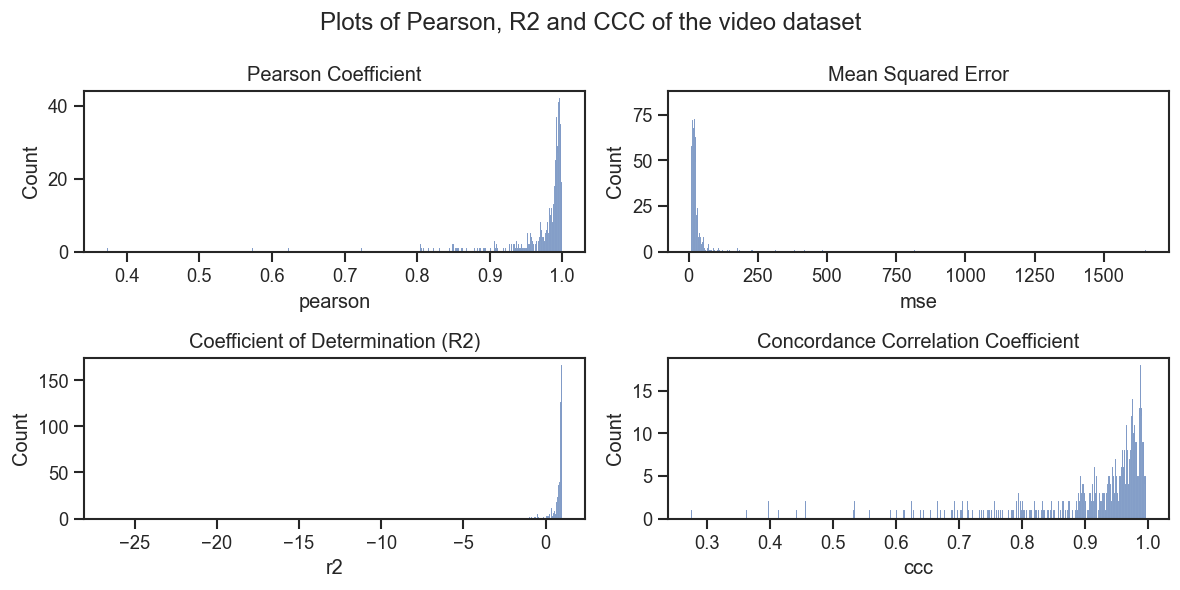

In [16]:
sns.set(rc={"figure.dpi":120})
sns.set_context('notebook')
sns.set_style("ticks")

fig, axes = plt.subplots(2,2, figsize=(10,5))
fig.suptitle('Plots of Pearson, R2 and CCC of the video dataset')
axes = axes.flatten()

# Pearson
axes[0].set_title('Pearson Coefficient')
sns.histplot(data=extracted_features_df_cleansed, x='pearson', bins=615, ax=axes[0])

# MSE
axes[1].set_title('Mean Squared Error')
sns.histplot(data=extracted_features_df_cleansed, x='mse', bins=615, ax=axes[1])

# R2
axes[2].set_title('Coefficient of Determination (R2)')
sns.histplot(data=extracted_features_df_cleansed, x='r2', bins=615, ax=axes[2])

# CCC
axes[3].set_title('Concordance Correlation Coefficient')
sns.histplot(data=extracted_features_df_cleansed, x='ccc', bins=615, ax=axes[3])

fig.tight_layout()
plt.show()

In [3]:
df = extracted_features_df_cleansed[extracted_features_df_cleansed.pearson < 0.8][['video', 'pearson']].sort_values(by='pearson')
videos_low_pearson = set(df['video'])
print('Numero di video con coefficiente di Pearson minore di 0.8:', len(df))
df

Numero di video con coefficiente di Pearson minore di 0.8: 8


,video,pearson
373,gta2_26,0.372659
186,david_bowie_13,0.508014
367,play_lastofus_202,0.572700
440,50_50_70,0.622480
96,happy_wheels_97,0.652695
136,TRY_NOT_LOOK_AWAY_21,0.692060
63,fatality_9,0.724103
318,dolan_dark_75,0.774220


In [42]:
df = extracted_features_df_cleansed[extracted_features_df_cleansed.mse > 50][['video', 'mse']].sort_values(by='mse')
videos_low_mse = set(df['video'])
print('Numero di video con MSE maggiore di 100:', len(df))
df

Numero di video con MSE maggiore di 100: 52


,video,mse
105,gta2_2,50.174280
602,happy_wheels_34,50.653865
155,gta1_46,50.723861
40,gta1_28,51.740916
323,qwop_21,51.906705
222,play_road_redemp_57,52.183573
179,happy_wheels_78,52.854227
513,happy_wheels_51,53.057293
364,happy_wheels_64,53.180854
39,happy_wheels_33,53.215337


In [41]:
df = extracted_features_df_cleansed[extracted_features_df_cleansed.r2 < 0.5][['video', 'r2']].sort_values(by='r2')
videos_low_r2 = set(df['video'])
print('Numero di video con R2 minore di 0.5:', len(df))
df

Numero di video con R2 minore di 0.5: 104


,video,r2
318,dolan_dark_75,-26.681080
136,TRY_NOT_LOOK_AWAY_21,-17.041159
493,50_50_77,-15.769022
367,play_lastofus_202,-6.725543
96,happy_wheels_97,-6.581751
...,...,...
319,play_red_dead_56,0.460172
244,cuphead_21,0.475597
525,play_lastofus_165,0.480051
330,japanese_show_85,0.481210


In [40]:
df = extracted_features_df_cleansed[extracted_features_df_cleansed.ccc < 0.8][['video', 'ccc']].sort_values(by='ccc')
videos_low_ccc = set(df['video'])
print('Numero di video con ccc minore di 0.8:', len(df))
df

Numero di video con ccc minore di 0.8: 88


,video,ccc
318,dolan_dark_75,0.274845
136,TRY_NOT_LOOK_AWAY_21,0.362347
493,50_50_77,0.397240
186,david_bowie_13,0.397492
85,play_road_redemp_49,0.413645
...,...,...
218,heartbeat_23,0.797000
490,qwop_93,0.797406
84,play_lastofus_146,0.798034
484,battlefield1_25,0.799125


In [5]:
videos_low_pearson.intersection(videos_low_r2).intersection(videos_low_ccc)

{'50_50_70',
 'TRY_NOT_LOOK_AWAY_21',
 'david_bowie_13',
 'dolan_dark_75',
 'fatality_9',
 'gta2_26',
 'happy_wheels_97',
 'play_lastofus_202'}

### Interpolated data

In [21]:
videos = []
videos_pearson = []
videos_mse = []
videos_r2 = []
videos_ccc = []
for video in os.listdir('dataset/ElderReact_Data/ElderReact_train/'):
    video = video[:-4]
    videos.append(video)
    
    landmarks = landmarks_mapper(video, data=2)
    videos_pearson.append(pearson(landmarks))
    videos_mse.append(mse(landmarks))
    videos_r2.append(r2(landmarks))
    videos_ccc.append(ccc(landmarks))

extracted_features_df_interpolated = pd.DataFrame({'video': videos, 'pearson': videos_pearson, 'mse': videos_mse, 'r2': videos_r2, 'ccc': videos_ccc})
%store extracted_features_df_interpolated
extracted_features_df_interpolated.to_csv('dataframes/pearson_mse_r2_ccc_interpolated.csv', index=False)
extracted_features_df_interpolated

Stored 'extracted_features_df_interpolated' (DataFrame)


,video,pearson,mse,r2,ccc
0,whack_your_boss_12,0.995737,7.317129,0.917630,0.963144
1,happy_wheels_54,0.996938,35.632308,0.979688,0.990167
2,would_you_rather_29,0.993759,11.984916,0.809299,0.922193
3,play_red_dead_138,0.945803,44.874668,0.738763,0.896052
4,Branda_schmitz_116,0.998589,16.845249,0.926901,0.966211
...,...,...,...,...,...
610,bully_burger_54,0.997151,9.738302,0.947245,0.975249
611,game_of_thrones_16,0.997354,8.054244,0.921995,0.964447
612,qwop_38,0.991607,30.649013,0.871138,0.944191
613,cuphead_58,0.988333,16.956480,0.839552,0.937180


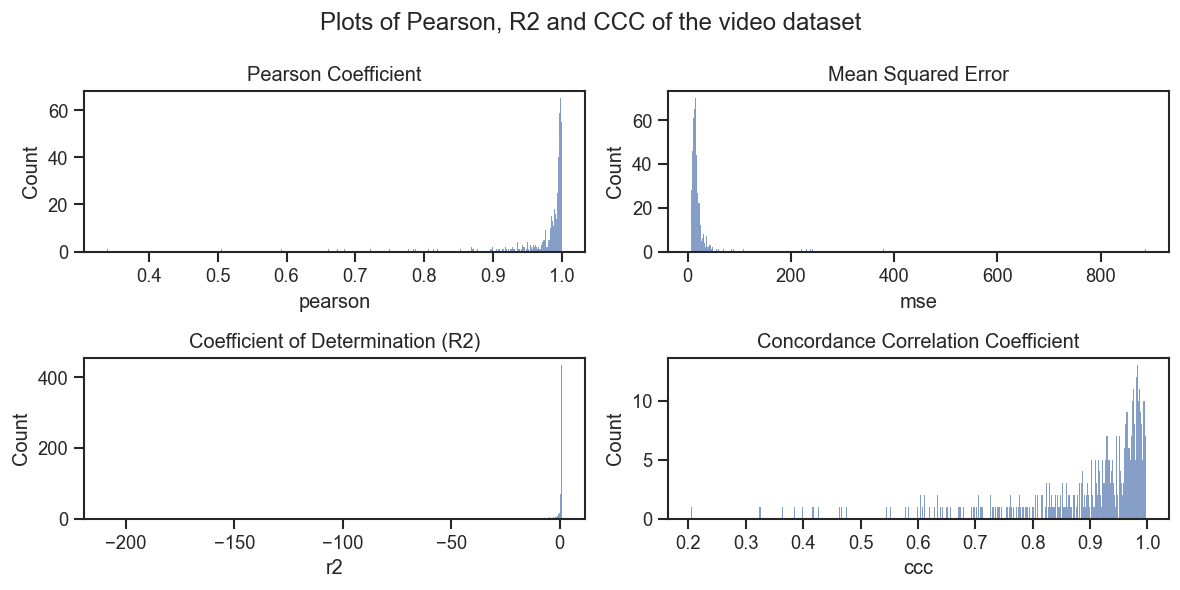

In [22]:
sns.set(rc={"figure.dpi":120})
sns.set_context('notebook')
sns.set_style("ticks")

fig, axes = plt.subplots(2,2, figsize=(10,5))
fig.suptitle('Plots of Pearson, R2 and CCC of the video dataset')
axes = axes.flatten()

# Pearson
axes[0].set_title('Pearson Coefficient')
sns.histplot(data=extracted_features_df_interpolated, x='pearson', bins=615, ax=axes[0])

# MSE
axes[1].set_title('Mean Squared Error')
sns.histplot(data=extracted_features_df_interpolated, x='mse', bins=615, ax=axes[1])

# R2
axes[2].set_title('Coefficient of Determination (R2)')
sns.histplot(data=extracted_features_df_interpolated, x='r2', bins=615, ax=axes[2])

# CCC
axes[3].set_title('Concordance Correlation Coefficient')
sns.histplot(data=extracted_features_df_interpolated, x='ccc', bins=615, ax=axes[3])

fig.tight_layout()
plt.show()

In [27]:
%store -r extracted_features_df_cleansed
%store -r extracted_features_df_interpolated

print('MSE before interpolation:', extracted_features_df_cleansed.mse.mean())
print('MSE after interpolation:', extracted_features_df_interpolated.mse.mean())

MSE before interpolation: 34.514035585391326
MSE after interpolation: 23.218632333300143


In [23]:
df = extracted_features_df_interpolated[extracted_features_df_interpolated.pearson < 0.8][['video', 'pearson']].sort_values(by='pearson')
videos_low_pearson = set(df['video'])
print('Numero di video con coefficiente di Pearson minore di 0.8:', len(df))
df

Numero di video con coefficiente di Pearson minore di 0.8: 11


,video,pearson
373,gta2_26,0.339363
407,play_red_dead_141,0.505048
367,play_lastofus_202,0.591943
136,TRY_NOT_LOOK_AWAY_21,0.661201
96,happy_wheels_97,0.673523
440,50_50_70,0.684579
605,gta1_1,0.722578
185,happy_wheels_63,0.748875
54,play_red_dead_124,0.776565
318,dolan_dark_75,0.784239


In [37]:
df = extracted_features_df_interpolated[extracted_features_df_interpolated.mse > 50][['video', 'mse']].sort_values(by='mse')
videos_low_mse = set(df['video'])
print('Numero di video con MSE maggiore di 100:', len(df))
df

Numero di video con MSE maggiore di 100: 20


,video,mse
31,vaping_for_the1st_42,53.337890
85,play_road_redemp_49,53.599327
269,happy_wheels_91,53.688705
322,Branda_schmitz_52,56.637907
447,qwop_39,60.371137
87,david_bowie_36,69.664173
176,50_50_4,85.588331
515,happy_wheels_44,89.772046
145,qwop_40,92.188136
190,rammstein_67,103.521814


In [38]:
df = extracted_features_df_interpolated[extracted_features_df_interpolated.r2 < 0.5][['video', 'r2']].sort_values(by='r2')
videos_low_r2 = set(df['video'])
print('Numero di video con R2 minore di 0.5:', len(df))
df

Numero di video con R2 minore di 0.5: 139


,video,r2
318,dolan_dark_75,-208.668520
185,happy_wheels_63,-33.369997
136,TRY_NOT_LOOK_AWAY_21,-30.323466
392,cuphead_38,-16.467185
493,50_50_77,-14.183073
...,...,...
330,japanese_show_85,0.479140
604,david_bowie_85,0.481027
131,vaping_for_the1st_81,0.482868
188,whack_your_boss_120,0.489294


In [39]:
df = extracted_features_df_interpolated[extracted_features_df_interpolated.ccc < 0.8][['video', 'ccc']].sort_values(by='ccc')
videos_low_ccc = set(df['video'])
print('Numero di video con ccc minore di 0.8:', len(df))
df

Numero di video con ccc minore di 0.8: 101


,video,ccc
318,dolan_dark_75,0.204520
136,TRY_NOT_LOOK_AWAY_21,0.323526
185,happy_wheels_63,0.324688
21,play_red_dead_119,0.363921
605,gta1_1,0.383898
...,...,...
141,bully_burger_50,0.791997
173,godofwar_3,0.794117
302,play_lastofus_82,0.796414
135,play_road_redemp_36,0.797062


In [26]:
videos_low_pearson.intersection(videos_low_r2).intersection(videos_low_ccc)

{'50_50_70',
 'TRY_NOT_LOOK_AWAY_21',
 'dolan_dark_75',
 'gta1_1',
 'gta2_26',
 'happy_wheels_63',
 'happy_wheels_97',
 'japanese_show_59',
 'play_lastofus_202',
 'play_red_dead_124',
 'play_red_dead_141'}